# Project 8: Machine Learning for Predictive Analytics

# **By Hrutik Naik**

## Packages and setup

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

#parameter settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## Reading data and initial processing

In [ ]:
#edit the file location of raw data set
cust_df=pd.read_csv("/content/Telecom Data.csv")
cust_df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


## Exercise

## Placeholder for your analysis

In [ ]:
# Type your code here to explore and understand the data better

#e.g., identify the dimension of cust_df
cust_df.shape




(51047, 58)

## Q1. Detect and resolve problems in the data (Missing value, Outliers, Unexpected value, etc.)

### Q1.1 How many customers had zero monthly revenue?

In [ ]:
#How many customers had zero monthly revenue?
#Exclude the customers with zero monthly revenue from cust_df and from any subsequent analysis
print('Customers with zero monthly revenue are: ', cust_df[cust_df['MonthlyRevenue'] == 0].shape[0])
cust_df = cust_df[cust_df['MonthlyRevenue'] != 0]


Customers with zero monthly revenue are:  6


### Q1.2 How many columns has missing values percentage > 5%

In [ ]:
#Calculate for each column % of missing value in the data
(cust_df.isna().sum() / cust_df.shape[0] * 100).sort_values(ascending=False)
print('')

#How many columns has missing values percentage > 5%
print('No columns are having more than 5% missing values.')

#What strategy should be used for imputation?
cust_df.dropna(axis=0, inplace=True)
cust_df.shape

AgeHH1                       1.780921
AgeHH2                       1.780921
PercChangeMinutes            0.715111
PercChangeRevenues           0.715111
MonthlyRevenue               0.305637
MonthlyMinutes               0.305637
TotalRecurringCharge         0.305637
DirectorAssistedCalls        0.305637
OverageMinutes               0.305637
RoamingCalls                 0.305637
ServiceArea                  0.047021
HandsetModels                0.001959
CurrentEquipmentDays         0.001959
Handsets                     0.001959
CustomerCareCalls            0.000000
CallWaitingCalls             0.000000
ActiveSubs                   0.000000
Churn                        0.000000
DroppedCalls                 0.000000
BlockedCalls                 0.000000
UniqueSubs                   0.000000
MonthsInService              0.000000
CallForwardingCalls          0.000000
UnansweredCalls              0.000000
DroppedBlockedCalls          0.000000
OffPeakCallsInOut            0.000000
PeakCallsInO


No columns are having more than 5% missing values.


(49748, 58)

<mark>__Result:__
    
We can drop those rows with missing values in them as the number of missing values are very less.

### Q1.3 For columns, "UniqueSubs" and "DirectorAssistedCalls" remove outliers, if any

Text(0.5, 1.0, 'Boxplot')

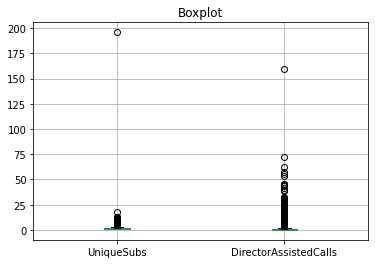

In [ ]:
#plot box plot using pandas for columns "UniqueSubs" and "DirectorAssistedCalls"
cols=["UniqueSubs","DirectorAssistedCalls"]
cust_df.boxplot(column=cols)
plt.title('Boxplot')

UniqueSubs               5.00
DirectorAssistedCalls    9.65
Name: 0.99, dtype: float64


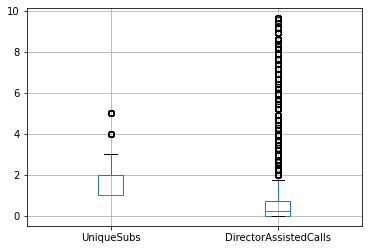

In [ ]:
#Remove top 1% outliers from the above mentioned two columns and plot the box plot again
#Use "quantile" function to identify top 1% outliers
print(cust_df[cols].quantile(0.99))

cust_df = cust_df[(cust_df['UniqueSubs'] <= 5) & (cust_df['DirectorAssistedCalls'] <= 9.65)]
cust_df.boxplot(column=cols)

## Q2. Perform exploratory analysis to analyze customer churn

### Q2.1 Does customers with high overage minutes also have high revenue?

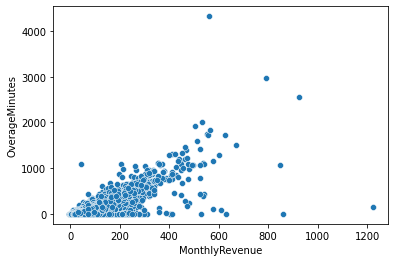

In [ ]:
#use scatter plot to find the correlation between monthly revenue and overage minutes
sns.scatterplot(x = 'MonthlyRevenue', y = 'OverageMinutes', data = cust_df)

<mark>__Result:__
    
We can see an positive correlation between these columns as we can see an upward trend.

### Q2.2 Does high number of active subscribers lead to low monthly revenue?

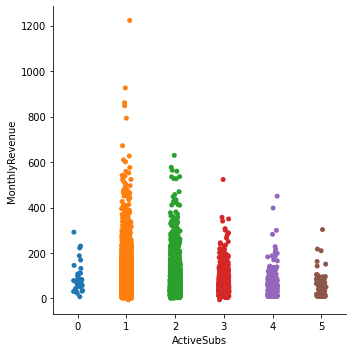

In [ ]:
#use category plot to plot monthly revenue for each active subs category
sns.catplot(x='ActiveSubs', y='MonthlyRevenue', data=cust_df)

<mark>__Result:__
    
It seems that with high number of active subscribers, the monthly revenue is decreasing

### Q2.3 Does credit rating have an impact in churn rate?

In [ ]:
# Percentage of customer churning based on their credit rating
credit_churn_1 = pd.crosstab(cust_df['Churn'], cust_df['CreditRating']).apply(lambda x: x/x.sum(), axis=0) * 100            # Row-wise calculation
credit_churn_2 = pd.crosstab(cust_df['Churn'], cust_df['CreditRating']).apply(lambda x: x/x.sum(), axis=1) * 100            # Column-wise calculation

display(credit_churn_1)
display(credit_churn_2)

CreditRating,1-Highest,2-High,3-Good,4-Medium,5-Low,6-VeryLow,7-Lowest
Churn,,,,,,,
No,69.346182,70.005934,69.23267,74.253007,78.229318,73.591549,71.294929
Yes,30.653818,29.994066,30.76733,25.746993,21.770682,26.408451,28.705071


CreditRating,1-Highest,2-High,3-Good,4-Medium,5-Low,6-VeryLow,7-Lowest
Churn,,,,,,,
No,16.234508,37.058084,16.000343,10.928665,13.852876,1.790508,4.135016
Yes,17.888667,39.578588,17.724943,9.446185,9.609909,1.601651,4.150057


<mark>__Result:__
    
We can see here that customer are churning without any relation to their credit rating. But one thing to notice here is that proportion of customer churning is higher for customers with high credit rating.

## Q3. Create additional features to help predict churn

In [ ]:
#wrapper function to create additional features for churn prediction
def create_features(cust_df):
    
    #3.1 Percent of current active subs over total subs
    cust_df['perc_Active_Subs'] = cust_df['ActiveSubs'] / cust_df['UniqueSubs']
    
    #3.2 Percent of recurrent charge to monthly charge
    #type your code here to create a new column in cust_df
    cust_df['perc_Recurring_Charge'] = cust_df['TotalRecurringCharge'] / cust_df['MonthlyRevenue']
    
    #3.3 Percent of overage minutes over total monthly minutes
    #type your code here to create a new column in cust_df
    cust_df['perc_Overage_Minutes'] = cust_df['OverageMinutes'] / cust_df['MonthlyMinutes']
    
    #type your code here to creat any other additional features which you think will help improve your model accuracy
    
    
    return cust_df 

In [ ]:
#Make a call to the feature engineering wrapper function for churn prediction
cust_df=create_features(cust_df)

#Checking for missing values
cust_df.isna().sum()
print()

#Investigating missing values
rows_with_nan = [index for index, value in cust_df['perc_Overage_Minutes'].iteritems() if np.isnan(value)]
cust_df.loc[rows_with_nan, ['OverageMinutes', 'MonthlyMinutes']]

#Filling missing value with 0
cust_df.fillna(value=0, axis=0, inplace=True)  


CustomerID                 0
Churn                      0
MonthlyRevenue             0
MonthlyMinutes             0
TotalRecurringCharge       0
                        ... 
Occupation                 0
MaritalStatus              0
perc_Active_Subs           0
perc_Recurring_Charge      0
perc_Overage_Minutes     667
Length: 61, dtype: int64

,OverageMinutes,MonthlyMinutes
4,0.0,0.0
90,0.0,0.0
110,0.0,0.0
152,0.0,0.0
212,0.0,0.0
...,...,...
50448,0.0,0.0
50571,0.0,0.0
50607,0.0,0.0
50745,0.0,0.0


In [ ]:
#Separating categorical and continuous variables
categorical_cols = list(cust_df.select_dtypes('object').columns.values)
continuous_cols = list(cust_df.select_dtypes('number').columns.values)

#Removing unnecessary columns and target variable
categorical_cols = [i for i in categorical_cols if i not in ('Churn', 'CustomerID', 'ServiceArea')]
continuous_cols.remove('CustomerID')

In [ ]:
#We are going to look for which columns from categorical columns we want to keep using chi-square test
def check_categorical_imp(cust_df, categorical_cols):
  new_categorical_cols = []
  for i in categorical_cols:
    if stats.chi2_contingency(pd.crosstab(cust_df['Churn'], cust_df[i]))[1] > 0.05:
      pass
    else:
      new_categorical_cols.append(i)

  return new_categorical_cols

In [ ]:
#Checking for class imbalance
cust_df['Churn'].value_counts(normalize=True) * 100

No     71.369176
Yes    28.630824
Name: Churn, dtype: float64

In [ ]:
#Encoding dependent variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cust_df['Churn'] = le.fit_transform(cust_df['Churn'])

class_0_count, class_1_count = cust_df['Churn'].value_counts()

class_0 = cust_df[cust_df['Churn'] == 0]
class_1 = cust_df[cust_df['Churn'] == 1]

class_1_over = class_1.sample(class_0_count, replace=True)                      # Using oversampling to fill dataframes with more data of churned customers.
test_over = pd.concat([class_1_over, class_0], axis=0)

# Assigning oversampled dataframe back to cust_df
cust_df = test_over
cust_df['Churn'].value_counts(normalize=True) * 100

1    50.0
0    50.0
Name: Churn, dtype: float64

## Q4. Build classification model to predict customer churn month in advance

### Initial data processing for model building exercise

In [ ]:
#Train - test split to train and test model accuracy
from sklearn.model_selection import train_test_split

#Define columns to be included in X and y
X = cust_df[check_categorical_imp(cust_df, categorical_cols) + continuous_cols]
y = cust_df['Churn']

#Encoding independent variable
#Create dummy variables for all categorical variables
X = pd.get_dummies(X, drop_first=True)

#Splitting the dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Feature scaling for all continuous variable
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()


In [ ]:
# Scaling testing and training data
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Q4.1 Build a simple logistic regression model to predict churn and evaluate model accuracy on test data set


In [ ]:
#-------------------------------- Model training -------------------------------#

#type your code to build logistic regression model on training data set
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, plot_confusion_matrix, average_precision_score, roc_curve, plot_roc_curve

#Creating an instance of Logistic Regression model
lr = LogisticRegression(random_state = 0)

#Training the model on training data
lr.fit(X_train, y_train)

#Predicting probabilities of customer churning in the test data
y_prediction_lr = lr.predict_proba(X_test)[:, 1]



LogisticRegression(random_state=0)

In [ ]:
#Finding the optimal threshold value
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_lr)

accuracy_lr = []
for i in thresholds:
    y_pred = np.where(y_prediction_lr > i, 1, 0)
    accuracy_lr.append(accuracy_score(y_test, y_pred))                          #Using accuracy for evaluation
    
accuracy_lr = pd.concat([pd.Series(thresholds), pd.Series(accuracy_lr)], axis=1)
accuracy_lr.columns = ['thresholds', 'accuracy']
accuracy_lr.sort_values('accuracy', ascending=False, inplace=True)
display(accuracy_lr[:5])                                                        #Top 5 best accuracy and their thresholds

best_threshold_lr = accuracy_lr.iloc[0, 0]                                      #Assigning best threshold to a variable




,thresholds,accuracy
5334,0.504829,0.583932
5336,0.504801,0.583885
5335,0.504818,0.583885
5333,0.504841,0.583885
5337,0.504788,0.583837


In [ ]:
#-------------------------------- Model testing ---------------------------------#

#type your code here to predict for X_test data set using the fitted model
y_prediction_lr = lr.predict_proba(X_test)[:, 1]

#Use a probability threshold to classify customers as churners and non churners (Default = 0.5)
y_prediction_lr[y_prediction_lr >= best_threshold_lr] = 1
y_prediction_lr[y_prediction_lr < best_threshold_lr] = 0

#Evaluate model accuracy using fitted y value and actual y_test
#Evaluatio metrics to be used - GINI, Precision, Recall, confusion matrix
print(classification_report(y_test, y_prediction_lr))
test_auc = roc_auc_score(y_test, y_prediction_lr)
print("Logistic Regression's roc-auc is: {}".format(test_auc))

print("\nconfusion matrix: \n{}".format(confusion_matrix(y_test, y_prediction_lr)))
tn, fp, fn, tp = confusion_matrix(y_test, y_prediction_lr).ravel()
print("\nTrue Negatives: {} \nFalse Positives: {} \nFalse Negatives: {} \nTrue Positives: {}".format(tn, fp, fn, tp))

              precision    recall  f1-score   support

           0       0.59      0.58      0.59     10641
           1       0.58      0.59      0.58     10370

    accuracy                           0.58     21011
   macro avg       0.58      0.58      0.58     21011
weighted avg       0.58      0.58      0.58     21011

Logistic Regression's roc-auc is: 0.5839252968608075

confusion matrix: 
[[6180 4461]
 [4282 6088]]

True Negatives: 6180 
False Positives: 4461 
False Negatives: 4282 
True Positives: 6088


Text(0.5, 0, 'fpr')

Text(0, 0.5, 'tpr')

Text(0.5, 1.0, 'ROC-AUC Curve for Logistic Regression')

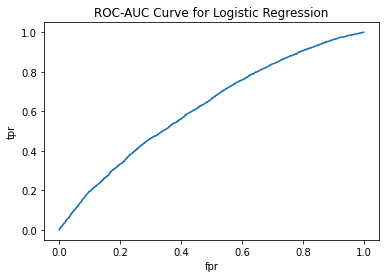

In [ ]:
#Plotting a roc curve
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC-AUC Curve for Logistic Regression')
plt.show()

### Q4.2 Build Random Forest classifier to compare model accuracy over the logistic regression model


In [ ]:
#-------------------------------- Model training -------------------------------#

#type your code to build random forest classifier model on training data set
from sklearn.ensemble import RandomForestClassifier

#Creating an instance of Random Forest Classifier model
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)

#Training the model on training data
rf.fit(X_train, y_train)

#Predicting probabilities of customer churning in test data
rf_test_output = rf.predict_proba(X_test)[:, 1]





RandomForestClassifier(criterion='entropy', random_state=0)

In [ ]:
#Finding the optimal threshold value
fpr, tpr, thresholds = roc_curve(y_test, rf_test_output)

accuracy_rf = []
for i in thresholds:
    y_pred = np.where(rf_test_output > i, 1, 0)
    accuracy_rf.append(accuracy_score(y_test, y_pred))                          #Using accuracy for evaluation
    
accuracy_rf = pd.concat([pd.Series(thresholds), pd.Series(accuracy_rf)], axis=1)
accuracy_rf.columns = ['thresholds', 'accuracy']
accuracy_rf.sort_values('accuracy', ascending=False, inplace=True)
display(accuracy_rf[:5])                                                        #Top 5 best accuracy and their thresholds

best_threshold_rf = accuracy_rf.iloc[0, 0]  

,thresholds,accuracy
38,0.63,0.909571
39,0.62,0.909476
40,0.61,0.909238
37,0.64,0.909143
36,0.65,0.908762


In [ ]:
#-------------------------------- Model testing ---------------------------------#

#type your code here to predict for X_test data set using the fitted RF model
rf_test_output = rf.predict_proba(X_test)[:, 1]

#Use a probability threshold to classify customers as churners and non churners (Default = 0.5)
rf_test_output[rf_test_output >= best_threshold_rf] = 1
rf_test_output[rf_test_output < best_threshold_rf] = 0

#Evaluate model accuracy using fitted y value and actual y_test
#Evaluatio metrics to be used - GINI, Precision, Recall, confusion matrix
print(classification_report(y_test, rf_test_output))
test_auc = roc_auc_score(y_test, rf_test_output)
print("Random Forest Classifier's roc-auc is: {}".format(test_auc))

print("\nconfusion matrix: \n{}".format(confusion_matrix(y_test, rf_test_output)))
tn, fp, fn, tp = confusion_matrix(y_test, rf_test_output).ravel()
print("\nTrue Negatives: {} \nFalse Positives: {} \nFalse Negatives: {} \nTrue Positives: {}".format(tn, fp, fn, tp))



              precision    recall  f1-score   support

           0       0.86      0.99      0.92     10641
           1       0.98      0.83      0.90     10370

    accuracy                           0.91     21011
   macro avg       0.92      0.91      0.91     21011
weighted avg       0.92      0.91      0.91     21011

Random Forest Classifier's roc-auc is: 0.9084626094171694

confusion matrix: 
[[10503   138]
 [ 1764  8606]]

True Negatives: 10503 
False Positives: 138 
False Negatives: 1764 
True Positives: 8606


Text(0.5, 0, 'fpr')

Text(0, 0.5, 'tpr')

Text(0.5, 1.0, 'ROC-AUC Curve for Random Forest Classifier model')

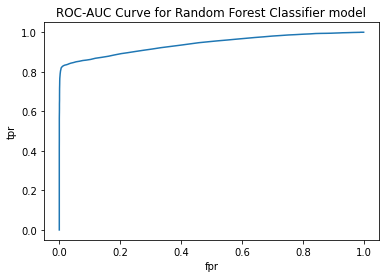

In [ ]:
#Plotting an roc curve for Random Forest Classifier model
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC-AUC Curve for Random Forest Classifier model')
plt.show()

<mark>__Result:__
    
The Random Forest Classifier model is having a better accuracy than the Logistic Regression model, we can see that as our accuracy_score, precision, recall and f1_score being more in Random Forest Classifier

### Q4.3 Identify most important features impacting churn

<Figure size 360x576 with 0 Axes>

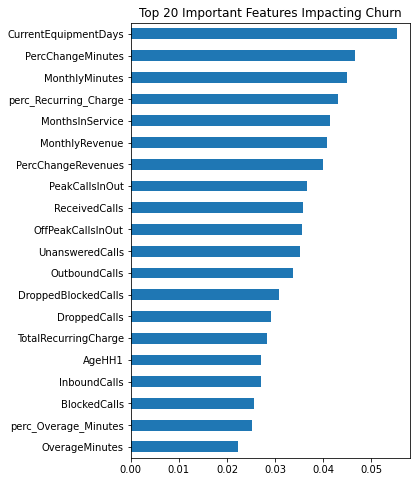

In [ ]:
# Type your code here to plot the top 20 important predictor features impacting churn using the Random Forest model created

top_20_features = pd.Series(rf.feature_importances_, index=X.columns).nlargest(20)
plt.figure(figsize=(5, 8))
top_20_features.sort_values(ascending=True).plot.barh(title='Top 20 Important Features Impacting Churn')

## Q5. Use the hold out data provided to predict churners using the best model identified in step 4 

In [ ]:
#Type your code here to predict churners based on the hold out data set provided
#Note #1: use "create_features(cust_df)" functions to create the additional list of features in the hold out data set
#Note #2: Also, perform feature scaling and dummy variables creation as performed during the initial stages of step #4
# predict = pd.read_csv("Telecom - Prediction Data.csv")
predict = pd.read_csv('/content/Telecom - Prediction Data.csv')

#Creating new features
create_features(cust_df=predict)

#Creating a copy of 'CustomerID' column
customer_id = predict['CustomerID']

#Selecting only the important columns from predict dataframe
predict = predict[check_categorical_imp(cust_df, categorical_cols) + continuous_cols]

#Dealing with missing values in newly created features
predict['perc_Overage_Minutes'].fillna(0, inplace=True)



,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,perc_Active_Subs,perc_Recurring_Charge,perc_Overage_Minutes
0,3000006,NaN,57.49,483.0,37.0,0.25,23.0,0.0,532.0,51.0,8.3,1.0,61.3,1.7,0.3,55.3,46.3,6.3,83.7,157.0,9.3,0.0,5.7,56,1,1,MILMIL414,7,6,240,30.0,0.0,No,No,Yes,Yes,Yes,Unknown,Yes,Yes,No,No,No,Yes,0,0,No,Yes,0,5,No,1,150,No,5-Low,Other,Other,No,1.000000,0.643590,0.047619
1,3000018,NaN,55.23,570.0,72.0,0.00,0.0,0.0,38.0,0.0,9.7,0.7,77.0,8.7,0.0,106.3,14.7,0.7,97.3,90.3,10.3,0.0,0.0,57,1,1,NNYSYR315,6,4,434,56.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,Yes,Yes,0,0,Yes,No,0,6,No,2,80,No,1-Highest,Other,Professional,No,1.000000,1.303639,0.000000
2,3000034,NaN,97.34,1039.0,50.0,4.95,420.0,0.0,198.0,23.3,12.7,3.0,176.0,11.3,0.3,213.9,103.3,0.3,238.3,192.3,15.7,0.0,4.0,55,1,1,MILMIL414,3,3,700,38.0,24.0,No,No,No,No,No,Unknown,No,No,No,No,No,No,0,0,Yes,No,0,4,No,3,10,No,3-Good,Suburban,Crafts,Yes,1.000000,0.513663,0.404235
3,3000070,NaN,35.59,153.0,30.0,0.00,16.0,0.0,30.0,7.3,2.0,0.7,17.3,0.0,0.0,33.1,8.0,4.7,48.3,7.0,2.7,0.0,0.3,59,3,2,SLCSLC801,6,5,48,46.0,0.0,Yes,No,Yes,Yes,Yes,Known,Yes,Yes,Yes,No,No,Yes,0,0,No,Yes,0,4,No,1,200,No,1-Highest,Other,Other,No,0.666667,0.842933,0.104575
4,3000074,NaN,55.27,1213.0,50.0,0.74,0.0,1.3,169.0,1.0,2.7,6.0,43.7,4.3,0.0,490.1,50.7,8.3,189.3,105.0,8.7,0.0,4.3,52,1,1,OKCTUL918,4,4,408,58.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,Yes,0,3,No,0,10,No,1-Highest,Suburban,Other,No,1.000000,0.904650,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3399938,NaN,85.15,815.0,88.0,0.00,1.0,0.4,0.0,0.0,12.0,0.0,15.3,0.0,1.3,141.0,9.0,3.3,72.0,38.7,12.0,0.0,0.0,27,3,2,LAXVNY818,3,3,230,64.0,64.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,Yes,0,0,No,No,0,0,No,0,40,No,1-Highest,Other,Other,Unknown,0.666667,1.033470,0.001227
19996,3399950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.7,0.0,0.0,0.0,25,1,1,LAXRIV909,1,1,773,34.0,26.0,No,No,Yes,No,No,Known,No,No,No,No,Yes,Yes,0,0,No,No,0,6,No,0,Unknown,No,1-Highest,Suburban,Other,Yes,1.000000,NaN,NaN
19997,3399966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.3,0.7,0.3,5.3,3.3,0.0,0.0,0.0,25,1,1,LAXCOR909,1,1,773,0.0,0.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,8,No,1,Unknown,No,1-Highest,Suburban,Other,No,1.000000,NaN,NaN
19998,3399970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,3.3,26.7,4.3,0.0,235.4,35.0,3.3,146.3,115.3,22.3,0.0,6.3,25,1,1,LAXLAG949,3,2,32,28.0,48.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,Yes,0,0,No,No,0,3,No,0,150,No,3-Good,Other,Other,Unknown,1.000000,NaN,NaN


In [ ]:
#Checking for missing values
missing_cols = []
for i, v in (predict.isna().sum() / predict.shape[0] * 100).iteritems():
    if v > 0:
        missing_cols.append(i)

#Filling missing values with median of each column
predict[missing_cols] = predict[missing_cols].fillna(predict[missing_cols].median(), axis=0)

In [ ]:
#Creating dummy variables
predict = pd.get_dummies(predict, drop_first=True)

In [ ]:
#Feature Scaling
X = sc.fit_transform(predict)

In [ ]:
#Use "predict" function on the transformend data using the best fitted model object
churn_pred = rf.predict(X)

#Adding a new column to check Customers who are going to churn
predict['Churn'] = churn_pred

#Adding 'CustomerID' column back to the predict dataframe
predict['CustomerID'] = customer_id
print(predict['Churn'].value_counts())

#Customers who are going to churn
predict.loc[predict['Churn'] == 1, ['CustomerID', 'Churn']]

0    17271
1     2729
Name: Churn, dtype: int64


,CustomerID,Churn
8,3000246,1
41,3000866,1
72,3001614,1
80,3001742,1
99,3002314,1
...,...,...
19916,3398310,1
19917,3398322,1
19923,3398418,1
19961,3399134,1
